<a href="https://colab.research.google.com/github/fabxy/course-content-dl/blob/main/tutorials/W2D5_GenerativeModels/W2D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Variational Autoencoders (VAEs)

**Week 2, Day 5: Generative Models**

**By Neuromatch Academy**

__Content creators:__ Saeed Salehi, Spiros Chavlis, Vikash Gilja

__Content reviewers:__ Diptodip Deb, Kelson Shilling-Scrivo

__Content editor:__ Charles J Edelson, Spiros Chavlis 

__Production editors:__ Saeed Salehi, Spiros Chavlis 

*Inspired from UPenn course*:
__Instructor:__ Konrad Kording, __Original Content creators:__ Richard Lange, Arash Ash

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives
In the first tutorial of the *Generative Models* day, we are going to

- Think about unsupervised learning / Generative Models and get a bird's eye view of why it is useful
- Build intuition about latent variables
- See the connection between AutoEncoders and PCA
- Start thinking about neural networks as generative models by contrasting AutoEncoders and Variational AutoEncoders

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in this tutorial

# @markdown If you want to locally download the slides, click [here](https://osf.io/rd7ng/download)
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/rd7ng/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
# @title Install dependencies
!pip install torchvision --quiet

# @markdown Install *Huggingface BigGAN* library

# @markdown Please ignore `Errors`/`Warnings` during installation.
!pip install pytorch-pretrained-biggan --quiet
!pip install Pillow libsixel-python --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W2D5_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

     |████████████████████████████████| 131 kB 7.9 MB/s 
     |████████████████████████████████| 7.8 MB 46.1 MB/s 
     |████████████████████████████████| 79 kB 6.3 MB/s 
     |████████████████████████████████| 138 kB 64.8 MB/s 
     |████████████████████████████████| 127 kB 67.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
# Imports
import torch
import random

import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from pytorch_pretrained_biggan import BigGAN
from pytorch_pretrained_biggan import one_hot_from_names
from pytorch_pretrained_biggan import truncated_noise_sample

from tqdm.notebook import tqdm, trange

In [4]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
from ipywidgets import interact, IntSlider, FloatSlider, interact_manual, fixed
from ipywidgets import FloatLogSlider, HBox, Layout, VBox, interactive, Label
from ipywidgets import interactive_output, Dropdown

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Helper functions

#@title Helper functions

def image_moments(image_batches, n_batches=None):
  """
  Compute mean an covariance of all pixels from batches of images
  """
  m1, m2 = torch.zeros((), device=DEVICE), torch.zeros((), device=DEVICE)
  n = 0
  for im in tqdm(image_batches, total=n_batches, leave=False,
                 desc='Computing pixel mean and covariance...'):
    im = im.to(DEVICE)
    b = im.size()[0]
    im = im.view(b, -1)
    m1 = m1 + im.sum(dim=0)
    m2 = m2 + (im.view(b,-1,1) * im.view(b,1,-1)).sum(dim=0)
    n += b
  m1, m2 = m1/n, m2/n
  cov = m2 - m1.view(-1,1)*m1.view(1,-1)
  return m1.cpu(), cov.cpu()


def interpolate(A, B, num_interps):
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  return np.array([(1-a)*A + a*B for a in alphas])


def kl_q_p(zs, phi):
  """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
  phi must be size [b,k+1]

  This uses mu_p = 0 and sigma_p = 1, which simplifies the log(p(zs)) term to
  just -1/2*(zs**2)
  """
  b, n, k = zs.size()
  mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
  log_p = -0.5*(zs**2)
  log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
  # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
  return (log_q - log_p).sum(dim=2).mean(dim=(0,1))


def log_p_x(x, mu_xs, sig_x):
  """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
  pixel-wise log Gaussian probability

  Sum over pixel dimensions, but mean over batch and samples.
  """
  b, n = mu_xs.size()[:2]
  # Flatten out pixels and add a singleton dimension [1] so that x will be
  # implicitly expanded when combined with mu_xs
  x = x.reshape(b, 1, -1)
  _, _, p = x.size()
  squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

  # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
  # Expected value requires mean over [n]. Handling different size batches
  # requires mean over [b].
  return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))


def pca_encoder_decoder(mu, cov, k):
  """
  Compute encoder and decoder matrices for PCA dimensionality reduction
  """
  mu = mu.view(1,-1)
  u, s, v = torch.svd_lowrank(cov, q=k)
  W_encode = v / torch.sqrt(s)
  W_decode = u * torch.sqrt(s)

  def pca_encode(x):
    # Encoder: subtract mean image and project onto top K eigenvectors of
    # the data covariance
    return (x.view(-1,mu.numel()) - mu) @ W_encode

  def pca_decode(h):
    # Decoder: un-project then add back in the mean
    return (h @ W_decode.T) + mu

  return pca_encode, pca_decode


def cout(x, layer):
  """Unnecessarily complicated but complete way to
  calculate the output depth, height and width size for a Conv2D layer

  Args:
    x (tuple): input size (depth, height, width)
    layer (nn.Conv2d): the Conv2D layer

  returns:
    (int): output shape as given in [Ref]

  Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  """
  assert isinstance(layer, nn.Conv2d)
  p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
  k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
  d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
  s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
  in_depth, in_height, in_width = x
  out_depth = layer.out_channels
  out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
  out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
  return (out_depth, out_height, out_width)

In [6]:
# @title Plotting functions

def plot_gen_samples_ppca(therm1, therm2, therm_data_sim):
  plt.plot(therm1, therm2, '.', c='c', label='training data')
  plt.plot(therm_data_sim[0], therm_data_sim[1], '.', c='m', label='"generated" data')
  plt.axis('equal')
  plt.xlabel('Thermometer 1 ($^\circ$C)')
  plt.ylabel('Thermometer 2 ($^\circ$C)')
  plt.legend()
  plt.show()


def plot_linear_ae(lin_losses):
  plt.figure()
  plt.plot(lin_losses)
  plt.ylim([0, 2*torch.as_tensor(lin_losses).median()])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.show()


def plot_conv_ae(lin_losses, conv_losses):
  plt.figure()
  plt.plot(lin_losses)
  plt.plot(conv_losses)
  plt.legend(['Lin AE', 'Conv AE'])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.ylim([0,
            2*max(torch.as_tensor(conv_losses).median(),
                  torch.as_tensor(lin_losses).median())])
  plt.show()


def plot_images(images, h=3, w=3, plt_title=''):
  plt.figure(figsize=(h*2, w*2))
  plt.suptitle(plt_title, y=1.03)
  for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plot_torch_image(images[i])
  plt.axis('off')
  plt.show()


def plot_phi(phi, num=4):
  plt.figure(figsize=(12, 3))
  for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.scatter(zs[i, :, 0], zs[i, :, 1], marker='.')
    th = torch.linspace(0, 6.28318, 100)
    x, y = torch.cos(th), torch.sin(th)
    # Draw 2-sigma contours
    plt.plot(
        2*x*phi[i, 2].exp().item() + phi[i, 0].item(),
        2*y*phi[i, 2].exp().item() + phi[i, 1].item()
        )
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.grid()
    plt.axis('equal')
  plt.suptitle('If rsample() is correct, then most but not all points should lie in the circles')
  plt.show()


def plot_torch_image(image, ax=None):
  ax = ax if ax is not None else plt.gca()
  c, h, w = image.size()
  if c==1:
    cm = 'gray'
  else:
    cm = None

  # Torch images have shape (channels, height, width) but matplotlib expects
  # (height, width, channels) or just (height,width) when grayscale
  im_plt = torch.clip(image.detach().cpu().permute(1,2,0).squeeze(), 0.0, 1.0)
  ax.imshow(im_plt, cmap=cm)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [10]:
# @title Download `wordnet` dataset

# import nltk
# nltk.download('wordnet')

import requests, zipfile

fname = 'wordnet.zip'
url = 'https://osf.io/ekjxy/download'
r = requests.get(url, allow_redirects=True)

with open('wordnet.zip', 'wb') as fd:
  fd.write(r.content)

with zipfile.ZipFile(fname, 'r') as zip_ref:
  zip_ref.extractall('/root/nltk_data/corpora')

---
# Section 1: Generative models

*Time estimate: ~15mins*

**Please** run the cell after the video to download BigGAN (a generative model) and a few standard image datasets while the video plays.

In [11]:
# @title Video 1: Generative Modeling
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Vy4y1j7cN", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"5EEx0sdyR_U", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Generative Modeling')


display(out)

In [12]:
# @markdown Download BigGAN (a generative model) and a few standard image datasets

## Initially was downloaded directly
# biggan_model = BigGAN.from_pretrained('biggan-deep-256')

url = "https://osf.io/3yvhw/download"
fname = "biggan_deep_256"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fd:
  fd.write(r.content)

biggan_model = torch.load(fname)

## Section 1.1: Generating Images from BigGAN

To demonstrate the power of generative models, we are giving you a sneak peek of a fully trained generative model called BigGAN. You’ll see it again (with more background under your belt) later today. For now, let’s just focus on BigGAN as a generative model. Specifically, BigGAN is a class conditional generative model for 128 x 128 images. The classes are based on categorical labels that describe the images and images are generated based upon a vector (z from the video lecture) and the probability that the image comes from a specific discrete category.

For now, don’t worry about the specifics of the model other than the fact that it generates images based on the vector and the category label.

To explore the space of generated images, we’ve provided you with a widget that allows you to select a category label and to alter the value of the vector. The vector is a 128-D, which may seem high dimensional, but is much lower-dimensional than a 128 x 128 image! To simplify usability the widget limits the magnitude of the vector and constrains all entries to be equal (so you are only exploring a subset of the possible images that can be generated).

### Think! 1.1: Generated images

As you alter the magnitude of the vector, what do you note about the relationship between the different generated images? What do you note about the relationship between the image and the category label as you increase the magnitude of the vector?

In [13]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [14]:
# @markdown BigGAN Image Generator (the updates may take a few seconds)

# category = 'German shepherd' # @param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
# z_magnitude = -16 # @param {type:"slider", min:-50, max:50, step:1}

def sample_from_biggan(category, z_magnitude):
  unit_vector = np.ones((1, 128))/np.sqrt(128)
  z = z_magnitude * unit_vector
  y = one_hot_from_names(category, batch_size=1)

  z = torch.from_numpy(z)
  z = z.float()
  y = torch.from_numpy(y)

  # Move to GPU
  z = z.to(device=set_device())
  y = y.to(device=set_device())
  biggan_model.to(device=set_device())

  with torch.no_grad():
    output = biggan_model(z, y, 1)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1] range.
  # Clipping is only in case of numerical instability problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)

  plt.imshow(output.squeeze().moveaxis(0,-1))
  plt.axis('off')

z_slider = IntSlider(min=-15, max=15, step=1, value=0,
                     continuous_update=False,
                     description='Z Magnitude',
                     layout=Layout(width='440px'))

category_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
             value="German shepherd",
             description="Category: ")

widgets_ui = VBox([category_dropdown, z_slider])

widgets_out = interactive_output(sample_from_biggan,
                                 {
                                     'z_magnitude': z_slider,
                                  'category': category_dropdown
                                  }
                                 )

display(widgets_ui, widgets_out)

Output()

## Section 1.2: Interpolating Images with BigGAN
This next widget allows you to interpolate between two generated images. It does this by linearly interpolating between the probability of each category you select and linearly interpolating between the latent vector values.

### Think! 1.2: Interpolating samples from the same category

Try interpolating between samples from the same category, samples from similar categories, and samples from very different categories. Do you notice any trends? What does this suggest about the representations of images in the latent space?

In [15]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [16]:
# @markdown BigGAN Interpolation Widget (the updates may take a few seconds)

def interpolate_biggan(category_A, z_magnitude_A, category_B, z_magnitude_B):
  num_interps = 16

  # category_A = 'jellyfish' #@param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
  # z_magnitude_A = 0 #@param {type:"slider", min:-10, max:10, step:1}

  # category_B = 'German shepherd' #@param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
  # z_magnitude_B = 0 #@param {type:"slider", min:-10, max:10, step:1}


  def interpolate_and_shape(A, B, num_interps):
    interps = interpolate(A, B, num_interps)
    return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                  .reshape(num_interps, *interps.shape[2:]))

  unit_vector = np.ones((1, 128))/np.sqrt(128)
  z_A = z_magnitude_A * unit_vector
  z_B = z_magnitude_B * unit_vector
  y_A = one_hot_from_names(category_A, batch_size=1)
  y_B = one_hot_from_names(category_B, batch_size=1)

  z_interp = interpolate_and_shape(z_A, z_B, num_interps)
  y_interp = interpolate_and_shape(y_A, y_B, num_interps)

  # Convert to tensor
  z_interp = torch.from_numpy(z_interp)
  z_interp = z_interp.float()
  y_interp = torch.from_numpy(y_interp)

  # Move to GPU
  z_interp = z_interp.to(DEVICE)
  y_interp = y_interp.to(DEVICE)
  biggan_model.to(DEVICE)

  with torch.no_grad():
    output = biggan_model(z_interp, y_interp, 1)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1] range.
  # Clipping is only in case of numerical instability problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)
  output = output

  # Make grid and show generated samples
  output_grid = torchvision.utils.make_grid(output,
                                            nrow=min(4, output.shape[0]),
                                            padding=5)
  plt.axis('off');
  plt.imshow(output_grid.permute(1, 2, 0))
  plt.show()


z_A_slider = IntSlider(min=-10, max=10, step=1, value=0,
                        continuous_update=False, description='Z Magnitude A',
                        layout=Layout(width='440px'), style={'description_width': 'initial'})

z_B_slider = IntSlider(min=-10, max=10, step=1, value=0,
                        continuous_update=False, description='Z Magntude B',
                        layout=Layout(width='440px'), style={'description_width': 'initial'})

category_A_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
                      value="German shepherd", description="Category A: ")

category_B_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
                      value="jellyfish", description="Category B: ")



widgets_ui = VBox([HBox([category_A_dropdown, z_A_slider]),
                   HBox([category_B_dropdown, z_B_slider])])

widgets_out = interactive_output(interpolate_biggan,
                                 {'category_A': category_A_dropdown,
                                  'z_magnitude_A': z_A_slider,
                                  'category_B': category_B_dropdown,
                                  'z_magnitude_B': z_B_slider})

display(widgets_ui, widgets_out)

Output()

---
# Section 2: Latent Variable Models

*Time estimate: ~15mins* excluding the Bonus

In [17]:
# @title Video 2: Latent Variable Models
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Db4y167Ys", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"_e0nKUeBDFo", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Latent Variable Models')

display(out)

In the video, the concept of a latent variable model was introduced. We saw how PCA (principal component analysis) can be extended into a generative model with latent variables called pPCA. For pPCA the latent variables (z in the video) are the projections onto the principal component axes. 

The dimensionality of the principal components is typically set to be substantially lower-dimensional than the original data. Thus, the latent variables (the projection onto the principal component axes) are a lower-dimensional representation of the original data (dimensionality reduction!). With pPCA we can estimate the original distribution of the high dimensional data. This allows us to generate data with a distribution that “looks” more like the original data than if we were to only use PCA to generate data from the latent variables. Let’s see how that might look with a simple example. 

## Coding Exercise 2: pPCA (Bonus)

Assume we have two noisy thermometers measuring the temperature of the same room. They both make noisy measurements.  The room tends to be around 25&deg;C (that's 77&deg;F), but can vary around that temperature.  If we take lots of readings from the two thermometers over time and plot the paired readings, we might see something like the plot generated below:

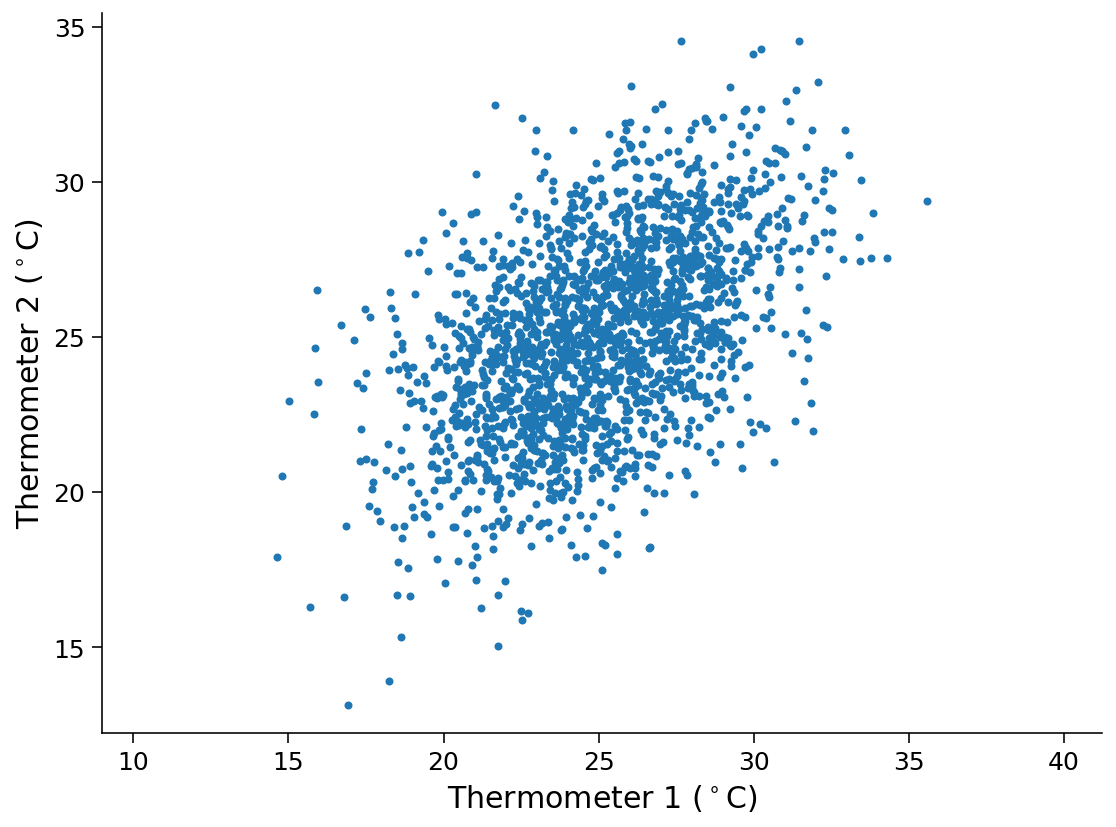

In [18]:
# @markdown Generate example datapoints from the two thermometers

def generate_data(n_samples, mean_of_temps, cov_of_temps, seed):
  """
  Generate random data, normally distributed

  Args:
    n_samples : int
      The number of samples to be generated
    mean_of_temps : numpy.ndarray
      1D array with the mean of temparatures, Kx1
    cov_of_temps : numpy.ndarray
      2D array with the covariance, , KxK
    seed : int
      Set random seed for the psudo random generator
  Returns:
    therm1 : numpy.ndarray
    therm2 : numpy.ndarray
  """

  np.random.seed(seed)
  therm1, therm2 = np.random.multivariate_normal(mean_of_temps,
                                                cov_of_temps,
                                                n_samples).T
  return therm1, therm2


n_samples = 2000
mean_of_temps = np.array([25, 25])
cov_of_temps = np.array([[10, 5], [5, 10]])
therm1, therm2 = generate_data(n_samples, mean_of_temps, cov_of_temps, seed=SEED)

plt.plot(therm1, therm2, '.')
plt.axis('equal')
plt.xlabel('Thermometer 1 ($^\circ$C)')
plt.ylabel('Thermometer 2 ($^\circ$C)')
plt.show()

Let’s model these data with a single principal component. Given that the thermometers are measuring the same actual temperature, the principal component axes will be the identity line. The direction of this axes can be indicated by the unit vector $[1 ~~ 1]~/~\sqrt2$.  We could estimate this axes by applying PCA. We can plot this axes, it tells us something about the data, but we can’t generate from it:

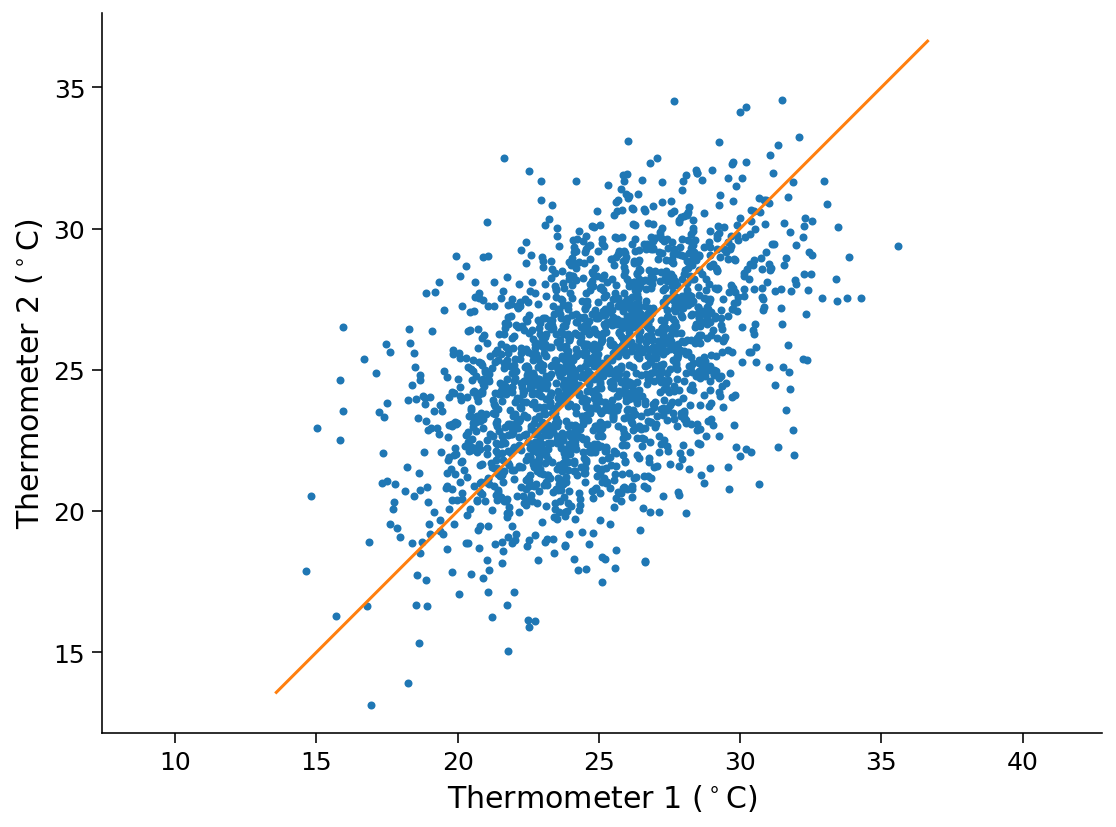

In [19]:
# @markdown Add first PC axes to the plot

plt.plot(therm1, therm2, '.')
plt.axis('equal')
plt.xlabel('Thermometer 1 ($^\circ$C)')
plt.ylabel('Thermometer 2 ($^\circ$C)')
plt.plot([plt.axis()[0], plt.axis()[1]],
         [plt.axis()[0], plt.axis()[1]])
plt.show()

**Step 1:** Calculate the parameters of the pPCA model

This part is completed already, so you don't need to make any edits:

(2000,)

In [21]:
# Project Data onto the principal component axes.
# We could have "learned" this from the data by applying PCA,
# but we "know" the value from the problem definition.
pc_axes = np.array([1.0, 1.0]) / np.sqrt(2.0)

# thermometers data
therm_data = np.array([therm1, therm2])

# Zero center the data
therm_data_mean = np.mean(therm_data, 1)
therm_data_center = np.outer(therm_data_mean, np.ones(therm_data.shape[1]))
therm_data_zero_centered = therm_data - therm_data_center

# Calculate the variance of the projection on the PC axes
pc_projection = np.matmul(pc_axes, therm_data_zero_centered);
pc_axes_variance = np.var(pc_projection)

# Calculate the residual variance (variance not accounted for by projection on the PC axes)
sensor_noise_std = np.mean(np.linalg.norm(therm_data_zero_centered - np.outer(pc_axes, pc_projection), axis=0, ord=2))
sensor_noise_var = sensor_noise_std **2

In [24]:
therm_data_center

array([[24.93591542, 24.93591542, 24.93591542, ..., 24.93591542,
        24.93591542, 24.93591542],
       [25.03562576, 25.03562576, 25.03562576, ..., 25.03562576,
        25.03562576, 25.03562576]])

**Step 2**: "Generate" from the pPCA model of the thermometer data.

Complete the code so it properly generates from the pPCA model. At present we aren't accounting for the "sensor noise" the sensor noise is the variance that the PC axes isn't accounting for. Thus, you'll note that the current output sits on the PC axes and doesn't look like the original data distribution!!

Here is the equation for sampling from the pPCA model:

\begin{equation}
x = \mu + W z + \epsilon, \,\text{where}\,~~ \epsilon \sim \mathcal{N}(0,~\sigma^2 \mathbf{I})
\end{equation}

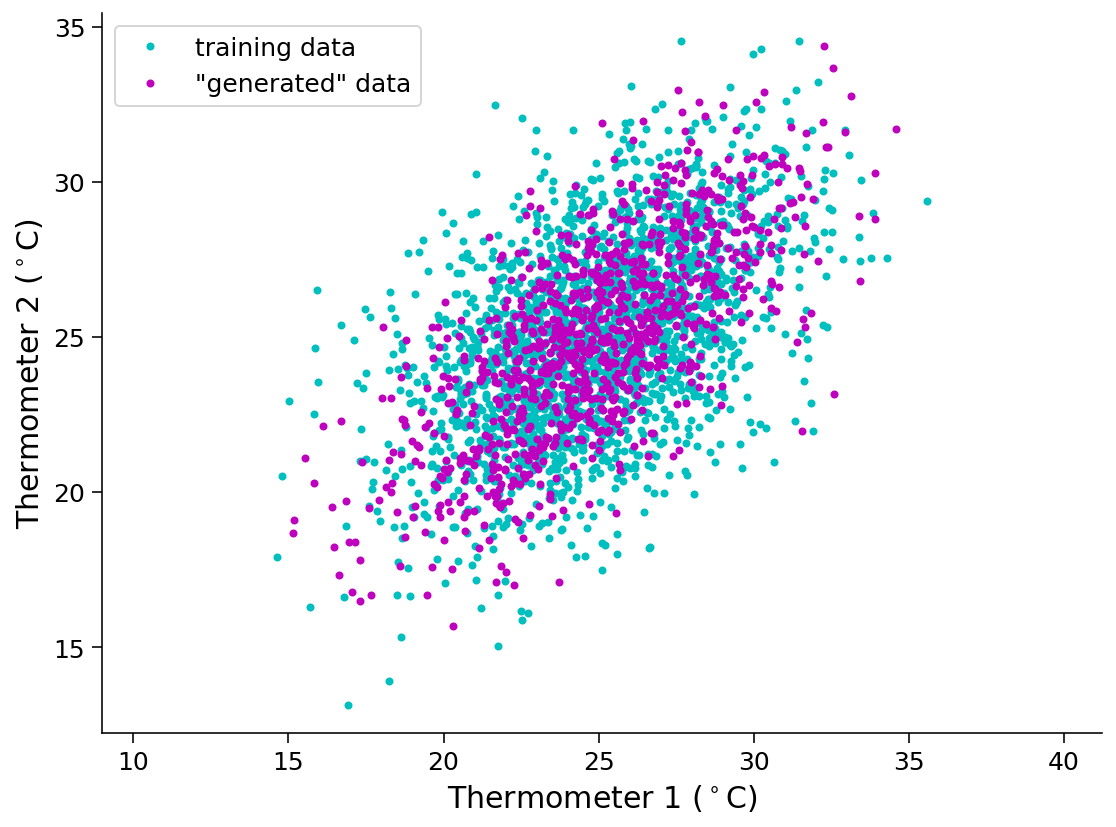

In [35]:
def gen_from_pPCA(noise_var, data_mean, pc_axes, pc_variance):
  """
  Args:
    noise_var (np.ndarray): sensor noise variance
    data_mean (np.ndarray): thermometer data mean
    pc_axes (np.ndarray): principal component axes
    pc_variance (np.ndarray): the variance of the projection on the PC axes
  """
  # We are matching this value to the thermometer data so the visualizations look similar
  n_samples = 1000

  # Randomly sample from z (latent space value)
  z = np.random.normal(0.0, np.sqrt(pc_variance), n_samples)

  # sensor noise covariance matrix (∑)
  epsilon_cov = [[noise_var, 0.0], [0.0, noise_var]]

  # data mean reshaped for the generation
  sim_mean = np.outer(data_mean, np.ones(n_samples))

  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your class
  #raise NotImplementedError("Please complete the `gen_from_pPCA` function")
  ####################################################################
  # draw `n_samples` from `np.random.multivariate_normal`
  rand_eps = np.random.multivariate_normal([0,0], epsilon_cov, size=n_samples)
  rand_eps = rand_eps.T

  # generate (simulate, draw) `n_samples` from pPCA model
  therm_data_sim = sim_mean + np.outer(pc_axes, z) + rand_eps

  return therm_data_sim


# add event to airtable
atform.add_event('Coding Exercise 2: pPCA')

# Uncomment to test your code
therm_data_sim = gen_from_pPCA(sensor_noise_var, therm_data_mean, pc_axes, pc_axes_variance)
plot_gen_samples_ppca(therm1, therm2, therm_data_sim)

In [ ]:
# to_remove solution
def gen_from_pPCA(noise_var, data_mean, pc_axes, pc_variance):
  """
  Args:
    noise_var (np.ndarray): sensor noise variance
    data_mean (np.ndarray): thermometer data mean
    pc_axes (np.ndarray): principal component axes
    pc_variance (np.ndarray): the variance of the projection on the PC axes
  """
  # We are matching this value to the thermometer data so the visualizations look similar
  n_samples = 1000

  # Randomly sample from z (latent space value)
  z = np.random.normal(0.0, np.sqrt(pc_variance), n_samples)

  # sensor noise covariance matrix (∑)
  epsilon_cov = [[noise_var, 0.0], [0.0, noise_var]]

  # data mean reshaped for the generation
  sim_mean = np.outer(data_mean, np.ones(n_samples))

  # draw `n_samples` from `np.random.multivariate_normal`
  rand_eps = np.random.multivariate_normal([0.0, 0.0], epsilon_cov, n_samples)
  rand_eps = rand_eps.T

  # generate (simulate, draw) `n_samples` from pPCA model
  therm_data_sim = sim_mean + np.outer(pc_axes, z) + rand_eps

  return therm_data_sim


# add event to airtable
atform.add_event('Coding Exercise 2: pPCA')

## Uncomment to test your code
therm_data_sim = gen_from_pPCA(sensor_noise_var, therm_data_mean, pc_axes, pc_axes_variance)
with plt.xkcd():
  plot_gen_samples_ppca(therm1, therm2, therm_data_sim)

---
# Section 3: Autoencoders

*Time estimate: ~30mins*

**Please** run the cell after the video to download MNIST and CIFAR10 image datasets while the video plays.

In [36]:
# @title Video 3: Autoenconders
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV16b4y167Z2", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"MlyIL1PmDCA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Autoenconders')

display(out)

In [37]:
# @markdown Download MNIST and CIFAR10 datasets
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed..\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been dowloaded.\n')


fname = 'cifar-10-python.tar.gz'
name = 'cifar10'
url = 'https://osf.io/jbpme/download'

if not os.path.exists(name):
  print('\nDownloading CIFAR10 dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading CIFAR10 completed.')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('CIFAR10 dataset has been dowloaded.')

In [38]:
# @markdown Load MNIST and CIFAR10 image datasets
# See https://pytorch.org/docs/stable/torchvision/datasets.html

# MNIST
mnist = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)
mnist_val = datasets.MNIST('./mnist/',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

# CIFAR 10
cifar10 = datasets.CIFAR10('./cifar10/',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)
cifar10_val = datasets.CIFAR10('./cifar10/',
                               train=False,
                               transform=transforms.ToTensor(),
                               download=False)

### Select a dataset

We've built today's tutorial to be flexible. It should work more-or-less out of the box with both MNIST and CIFAR (and other image datasets). MNIST is in many ways simpler, and the results will likely look better and run a bit faster if using MNIST. But we are leaving it up to you to pick which one you want to experiment with!

We encourage pods to coordinate so that some members use MNIST and others use CIFAR10. Keep in mind that the CIFAR dataset may require more learning epochs (longer training required).

In [39]:
def get_data(name='mnist'):
  if name == 'mnist':
    my_dataset_name = "MNIST"
    my_dataset = mnist
    my_valset = mnist_val
    my_dataset_shape = (1, 28, 28)
    my_dataset_size = 28 * 28
  elif name == 'cifar10':
    my_dataset_name = "CIFAR10"
    my_dataset = cifar10
    my_valset = cifar10_val
    my_dataset_shape = (3, 32, 32)
    my_dataset_size = 3 * 32 * 32

  return my_dataset, my_dataset_name, my_dataset_shape, my_dataset_size, my_valset


train_set, dataset_name, data_shape, data_size, valid_set = get_data(name='mnist')

## Section 3.1: Conceptual introduction to AutoEncoders

Now we'll create our first autoencoder. It will reduce images down to $K$ dimensions. The architecture will be quite simple: the input will be linearly mapped to a single hidden (or latent) layer $\mathbf{h}$ with $K$ units, which will then be linearly mapped back to an output that is the same size as the input:

\begin{equation}
\mathbf{x} \longrightarrow \mathbf{h} \longrightarrow \mathbf{x'}
\end{equation}

The loss function we'll use will simply be mean squared error (MSE) quantifying how well the reconstruction ($\mathbf{x'}$) matches the original image ($\mathbf{x}$):

\begin{equation}
\text{MSE Loss} = \sum_{i=1}^{N} ||\mathbf{x}_i - \mathbf{x'}_i||^2_2
\end{equation}

If all goes well, then the AutoEncoder will learn, **end to end**, a good "encoding" or "compression" of inputs to a latent representation ($\mathbf{x \longrightarrow h}$) as well as a good "decoding" of that latent representation to a reconstruction of the original input ($\mathbf{h \longrightarrow x'}$).

The first choice to make is the dimensionality of $\mathbf{h}$. We'll see more on this below, but For MNIST, 5 to 20 is plenty. For CIFAR, we need more like 50 to 100 dimensions.

Coordinate with your pod to try a variety of values for $K$ in each dataset so you can compare results.

### Coding Exercise 3.1: Linear AutoEncoder Architecture

Complete the missing parts of the `LinearAutoEncoder` class.

The `LinearAutoEncoder` as two stages: an `encoder` which linearly maps from inputs of size `x_dim = my_dataset_dim` to a hidden layer of size `h_dim = K` (with no nonlinearity), and a `decoder` which maps back from `K` up to the number of pixels in each image.

In [40]:
# @markdown #### Run to define the `train_autoencoder` function.
# @markdown Feel free to inspect the training function if the time allows.

# @markdown `train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250, seed=0)`


def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250,
                      seed=0):
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-3,
                           weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      worker_init_fn=seed_worker,
                      generator=g_seed)

  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  i = 0
  for epoch in trange(epochs, desc='Epoch'):
    for im_batch, _ in loader:
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      # write the loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1
  # After training completes, make sure the model is on CPU so we can easily
  # do more visualizations and demos.
  autoencoder.to('cpu')
  return mse_loss.cpu()

Random seed 2021 has been set.


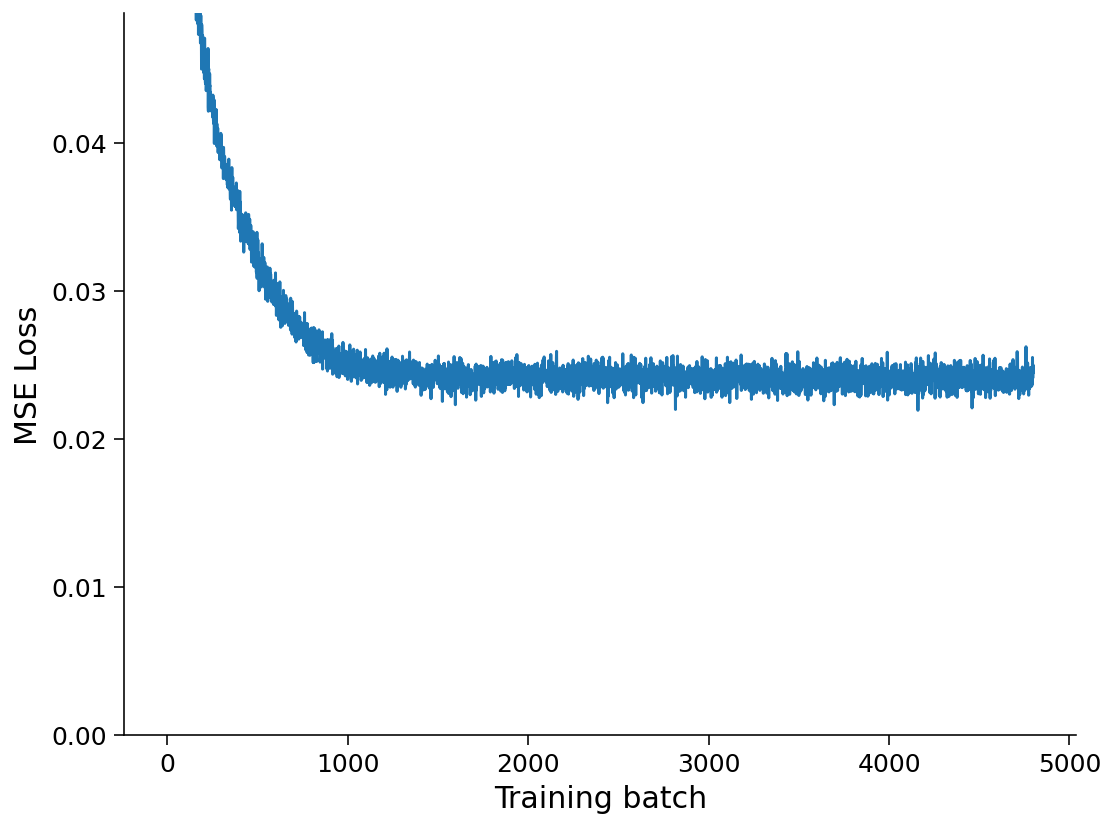

In [41]:
class LinearAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim):
    """A Linear AutoEncoder

    Args:
      x_dim (int): input dimension
      h_dim (int): hidden dimension, bottleneck dimension, K
    """
    super().__init__()
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your class
    # raise NotImplementedError("Please complete the LinearAutoEncoder class!")
    ####################################################################
    # encoder layer (a linear mapping from x_dim to K)
    self.enc_lin = nn.Linear(x_dim, h_dim)
    # decoder layer (a linear mapping from K to x_dim)
    self.dec_lin = nn.Linear(h_dim, x_dim)

  def encode(self, x):
    ####################################################################
    # Fill in all missing code below (...),
    #raise NotImplementedError("Please complete the `encode` function!")
    ####################################################################
    h = self.enc_lin(x)
    return h

  def decode(self, h):
    ####################################################################
    # Fill in all missing code below (...),
    #raise NotImplementedError("Please complete the `decode` function!")
    ####################################################################
    x_prime = self.dec_lin(h)
    return x_prime

  def forward(self, x):
    flat_x = x.view(x.size(0), -1)
    h = self.encode(flat_x)
    return self.decode(h).view(x.size())


# add event to airtable
atform.add_event('Coding Exercise 3.1: Linear AutoEncoder Architecture')

# Pick your own K
K = 20
set_seed(seed=SEED)
# Uncomment to test your code
lin_ae = LinearAutoEncoder(data_size, K)
lin_losses = train_autoencoder(lin_ae, train_set, device=DEVICE, seed=SEED)
plot_linear_ae(lin_losses)

In [ ]:
# to_remove solution
class LinearAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim):
    """A Linear AutoEncoder

    Args:
      x_dim (int): input dimension
      h_dim (int): hidden dimension, bottleneck dimension, K
    """
    super().__init__()
    # encoder layer (a linear mapping from x_dim to K)
    self.enc_lin = nn.Linear(x_dim, h_dim)
    # decoder layer (a linear mapping from K to x_dim)
    self.dec_lin = nn.Linear(h_dim, x_dim)

  def encode(self, x):
    h = self.enc_lin(x)
    return h

  def decode(self, h):
    x_prime = self.dec_lin(h)
    return x_prime

  def forward(self, x):
    flat_x = x.view(x.size(0), -1)
    h = self.encode(flat_x)
    return self.decode(h).view(x.size())


# add event to airtable
atform.add_event('Coding Exercise 3.1: Linear AutoEncoder Architecture')

# Pick your own K
K = 20
set_seed(seed=SEED)
## Uncomment to test your code
lin_ae = LinearAutoEncoder(data_size, K)
lin_losses = train_autoencoder(lin_ae, train_set, device=DEVICE, seed=SEED)
with plt.xkcd():
  plot_linear_ae(lin_losses)

### Comparison to PCA

One way to think about AutoEncoders is as a form of dimensionality-reduction. The dimensionality of $\mathbf{h}$ is much smaller than the dimensionality of $\mathbf{x}$.

Another common technique for dimensionality reduction is to project data onto the top $K$ **principal components** (Principal Component Analysis or PCA). For comparison, let's also apply PCA for dimensionality reduction.

In [42]:
# PCA requires finding the top K eigenvectors of the data covariance. Start by
# finding the mean and covariance of the pixels in our dataset
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

loader = DataLoader(train_set,
                    batch_size=32,
                    pin_memory=True,
                    num_workers=2,
                    worker_init_fn=seed_worker,
                    generator=g_seed)

mu, cov = image_moments((im for im, _ in loader),
                        n_batches=len(train_set) // 32)

pca_encode, pca_decode = pca_encoder_decoder(mu, cov, K)

Let's visualize some of the reconstructions ($\mathbf{x'}$) side-by-side with the input images ($\mathbf{x}$).

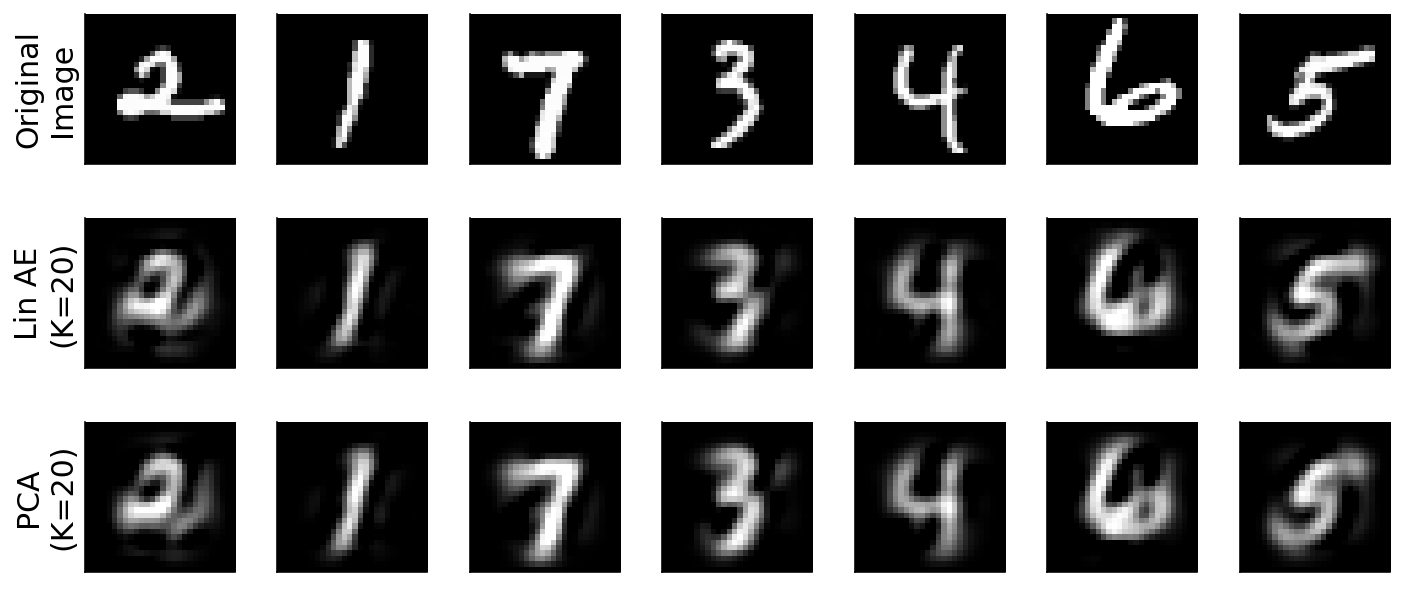

In [43]:
# @markdown Visualize the reconstructions $\mathbf{x}'$, run this code a few times to see different examples.

n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(train_set), size=())
  image, _ = train_set[idx]
  # Get reconstructed image from autoencoder
  with torch.no_grad():
    reconstruction = lin_ae(image.unsqueeze(0)).reshape(image.size())

  # Get reconstruction from PCA dimensionality reduction
  h_pca = pca_encode(image)
  recon_pca = pca_decode(h_pca).reshape(image.size())

  plt.subplot(3, n_plot, i + 1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(reconstruction)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(recon_pca)
  if i == 0:
    plt.ylabel(f'PCA\n(K={K})')
plt.show()

### Think! 3.1: PCA vs. Linear autoenconder

Compare the PCA-based reconstructions to those from the linear autoencoder. Is one better than the other? Are they equally good? Equally bad? How does the choice of $K$ impact reconstruction quality?

In [44]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q3' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

Submission successful!


## Section 3.2: Building a nonlinear convolutional autoencoder

**Nonlinear:** We'd like to apply autoencoders to learn a more flexible nonlinear mapping between the latent space and the images. Such a mapping can provide a more "expressive" model that better describes the image data than a linear mapping. This can be achieved by adding nonlinear activation functions to our encoder and decoder!

**Convolutional:** As you saw on the day dedicated to RNNs and CNNs, parameter sharing is often a good idea for images! It's quite common to use convolutional layers in autoencoders to share parameters across locations in the image.

**Side Note:** The `nn.Linear` layer (used in the linear autoencoder above) has a "bias" term, which is a learnable offset parameter separate for each output unit. Just like PCA "centers" the data by subtracting off the mean image (`mu`) before encoding and adds the average back in during decoding, a bias term in the decoder can effectively account for the first moment (mean) of the data (i.e. the average of all images in the training set). Convolution layers do have bias parameters, but the bias is applied per filter rather than per pixel location. If we're generating grayscale images (like those in MNIST), then `Conv2d` will learn only one bias across the entire image.

For some conceptual continuity with both PCA and the `nn.Linear` layers above, the next block defines a custom `BiasLayer` for adding a learnable per-pixel offset. This custom layer will be used twice: as the first stage of the encoder and as the final stage of the decoder. Ideally, this means that the rest of the neural net can focus on fitting more interesting fine-grained structure.

In [47]:
class BiasLayer(nn.Module):
  def __init__(self, shape):
    super(BiasLayer, self).__init__()
    init_bias = torch.zeros(shape)
    self.bias = nn.Parameter(init_bias, requires_grad=True)

  def forward(self, x):
    return x + self.bias

With that out of the way, we will next define a **nonlinear** and **convolutional** autoencoder. Here's a quick tour of the architecture:

1. The **encoder** once again maps from images to $\mathbf{h}\in\mathbb{R}^K$. This will use a `BiasLayer` followed by two convolutional layers (`nn.Conv2D`), followed by flattening and linearly projecting down to $K$ dimensions. The convolutional layers will have `ReLU` nonlinearities on their outputs. 
1. The **decoder** inverts this process, taking in vectors of length $K$ and outputting images. Roughly speaking, its architecture is a "mirror image" of the encoder: the first decoder layer is linear, followed by two **deconvolution** layers ([`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)). The `ConvTranspose2d`layers will have `ReLU` nonlinearities on their _inputs_. This "mirror image" between the encoder and decoder is a useful and near-ubiquitous convention. The idea is that the decoder can then learn to approximately invert the encoder, but it is not a strict requirement (and it does not guarantee the decoder will be an exact inverse of the encoder!).

Below is a schematic of the architecture for MNIST. Notice that the width and height dimensions of the image planes reduce after each `nn.Conv2d` and increase after each `nn.ConvTranspose2d`. With CIFAR10, the architecture is the same but the exact sizes will differ.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D5_GenerativeModels/static/conv_sizes.png">

[`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) module can be seen as the gradient of `Conv2d` with respect to its input. It is also known as a fractionally-strided convolution or a deconvolution (although it is not an actual deconvolution operation). The following code demonstrates this change in sizes:

In [45]:
dummy_image = torch.rand(data_shape).unsqueeze(0)
in_channels = data_shape[0]
out_channels = 7

dummy_conv = nn.Conv2d(in_channels=in_channels,
                       out_channels=out_channels,
                       kernel_size=5)

dummy_deconv = nn.ConvTranspose2d(in_channels=out_channels,
                                  out_channels=in_channels,
                                  kernel_size=5)

print(f'Size of image is {dummy_image.shape}')
print(f'Size of Conv2D(image) {dummy_conv(dummy_image).shape}')
print(f'Size of ConvTranspose2D(Conv2D(image)) {dummy_deconv(dummy_conv(dummy_image)).shape}')

Size of image is torch.Size([1, 1, 28, 28])
Size of Conv2D(image) torch.Size([1, 7, 24, 24])
Size of ConvTranspose2D(Conv2D(image)) torch.Size([1, 1, 28, 28])


### Coding Exercise 3.2: Fill in code for the `ConvAutoEncoder` module

Complete the `ConvAutoEncoder` class. We use the helper function `cout(torch.Tensor, nn.Conv2D)` to calculate the output shape of a [`nn.Conv2D`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer given a tensor with shape (channels, height, width).

In [48]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
    """A Convolutional AutoEncoder

    Args:
      x_dim (tuple): input dimensions (channels, height, widths)
      h_dim (int): hidden dimension, bottleneck dimension, K
      n_filters (int): number of filters (number of output channels)
      filter_size (int): kernel size
    """
    super().__init__()
    channels, height, widths = x_dim

    # encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # first encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    # second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()

    # conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    # encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your class
    # Remember that decoder is "undo"-ing what the encoder has done!
    # raise NotImplementedError("Please complete the `ConvAutoEncoder` class!")
    ####################################################################
    # decoder Linear layer
    self.dec_lin = nn.Linear(h_dim, flat_after_conv)

    # unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # first "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # second "deconvolution" layer
    self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

    # decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    s = self.enc_bias(x)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    return x_prime

  def forward(self, x):
    return self.decode(self.encode(x))


# add event to airtable
atform.add_event('Coding Exercise 3.2: Fill in code for the ConvAutoEncoder module')

K = 20
set_seed(seed=SEED)
# Uncomment to test your solution
trained_conv_AE = ConvAutoEncoder(data_shape, K)
assert trained_conv_AE.encode(train_set[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
conv_losses = train_autoencoder(trained_conv_AE, train_set, device=DEVICE, seed=SEED)
plot_conv_ae(lin_losses, conv_losses)

Random seed 2021 has been set.


KeyboardInterrupt: ignored

In [ ]:
# to_remove solution
class ConvAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
    """A Convolutional AutoEncoder

    Args:
      x_dim (tuple): input dimensions (channels, height, widths)
      h_dim (int): hidden dimension, bottleneck dimension, K
      n_filters (int): number of filters (number of output channels)
      filter_size (int): kernel size
    """
    super().__init__()
    channels, height, widths = x_dim

    # encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # first encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    # second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()

    # conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    # encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    # decoder Linear layer
    self.dec_lin = nn.Linear(h_dim, flat_after_conv)

    # unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # first "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # second "deconvolution" layer
    self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

    # decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    s = self.enc_bias(x)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    return x_prime

  def forward(self, x):
    return self.decode(self.encode(x))


# add event to airtable
atform.add_event('Coding Exercise 3.2: Fill in code for the ConvAutoEncoder module')

K = 20
set_seed(seed=SEED)
## Uncomment to test your solution
trained_conv_AE = ConvAutoEncoder(data_shape, K)
assert trained_conv_AE.encode(train_set[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
conv_losses = train_autoencoder(trained_conv_AE, train_set, device=DEVICE, seed=SEED)
with plt.xkcd():
  plot_conv_ae(lin_losses, conv_losses)

You should see that the `ConvAutoEncoder` achieved lower MSE loss than the linear one. If not, you may need to retrain it (or run another few training epochs from where it left off). We make fewer guarantees on this working with CIFAR10, but it should definitely work with MNIST.

Now let's visually compare the reconstructed images from the linear and nonlinear autoencoders. Keep in mind that both have the same dimensionality for $\mathbf{h}$!

In [ ]:
# @markdown Visualize the linear and nonlinear AE outputs
n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(train_set), size=())
  image, _ = train_set[idx]
  with torch.no_grad():
    # Get reconstructed image from linear autoencoder
    lin_recon = lin_ae(image.unsqueeze(0))[0]

    # Get reconstruction from deep (nonlinear) autoencoder
    nonlin_recon = trained_conv_AE(image.unsqueeze(0))[0]

  plt.subplot(3, n_plot, i+1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(lin_recon)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(nonlin_recon)
  if i == 0:
    plt.ylabel(f'NonLin AE\n(K={K})')
plt.show()

---
# Section 4: Variational Auto-Encoders (VAEs)

*Time estimate: ~25mins*

**Please** run the cell after the video to train a VAE for MNIST while watching it.

In [49]:
# @title Video 4: Variational Autoencoders
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV17v411E7ye", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"srWb_Gp6OGA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Variational Autoencoders')

display(out)


Learned sigma_x is 0.20865567028522491


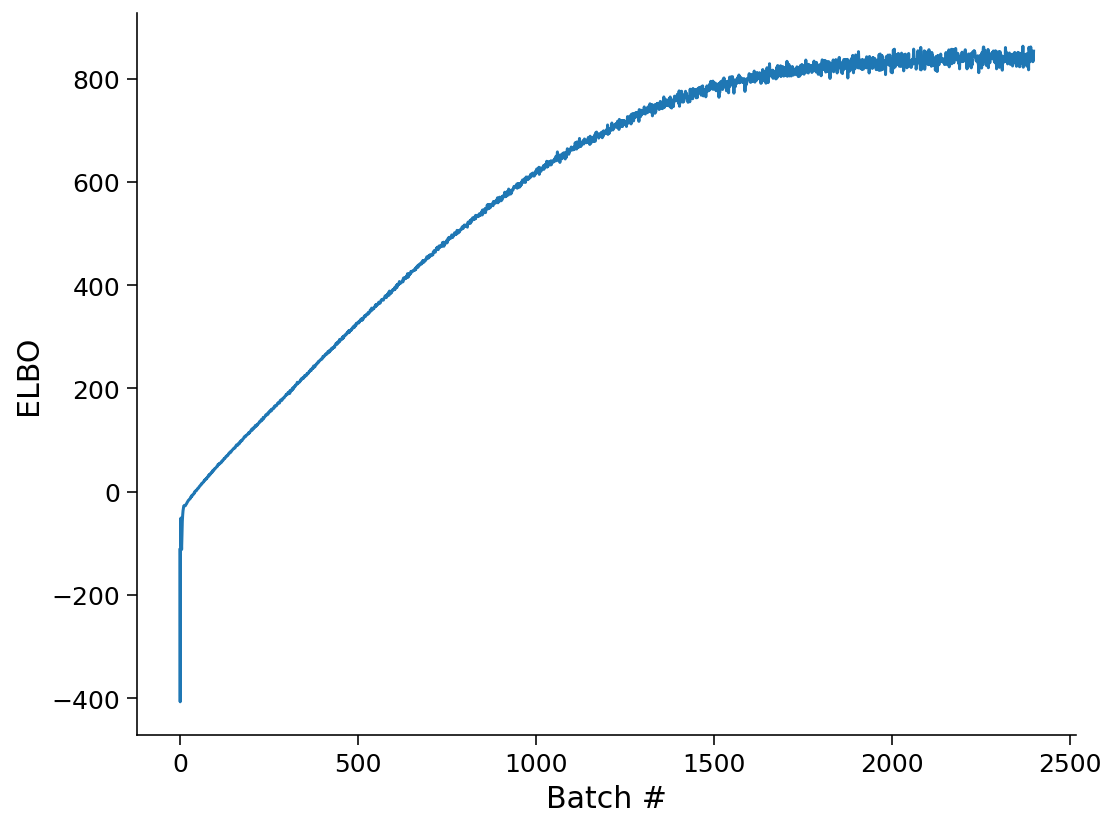

In [50]:
K_VAE = 2


class ConvVAE(nn.Module):
  def __init__(self, K, num_filters=32, filter_size=5):
    super(ConvVAE, self).__init__()

    # With padding=0, the number of pixels cut off from each image dimension
    # is filter_size // 2. Double it to get the amount of pixels lost in
    # width and height per Conv2D layer, or added back in per
    # ConvTranspose2D layer.
    filter_reduction = 2 * (filter_size // 2)

    # After passing input through two Conv2d layers, the shape will be
    # 'shape_after_conv'. This is also the shape that will go into the first
    # deconvolution layer in the decoder
    self.shape_after_conv = (num_filters,
                              data_shape[1]-2*filter_reduction,
                              data_shape[2]-2*filter_reduction)
    flat_size_after_conv = self.shape_after_conv[0] \
        * self.shape_after_conv[1] \
        * self.shape_after_conv[2]

    # Define the recognition model (encoder or q) part
    self.q_bias = BiasLayer(data_shape)
    self.q_conv_1 = nn.Conv2d(data_shape[0], num_filters, 5)
    self.q_conv_2 = nn.Conv2d(num_filters, num_filters, 5)
    self.q_flatten = nn.Flatten()
    self.q_fc_phi = nn.Linear(flat_size_after_conv, K+1)

    # Define the generative model (decoder or p) part
    self.p_fc_upsample = nn.Linear(K, flat_size_after_conv)
    self.p_unflatten = nn.Unflatten(-1, self.shape_after_conv)
    self.p_deconv_1 = nn.ConvTranspose2d(num_filters, num_filters, 5)
    self.p_deconv_2 = nn.ConvTranspose2d(num_filters, data_shape[0], 5)
    self.p_bias = BiasLayer(data_shape)

    # Define a special extra parameter to learn scalar sig_x for all pixels
    self.log_sig_x = nn.Parameter(torch.zeros(()))

  def infer(self, x):
    """Map (batch of) x to (batch of) phi which can then be passed to
    rsample to get z
    """
    s = self.q_bias(x)
    s = F.relu(self.q_conv_1(s))
    s = F.relu(self.q_conv_2(s))
    flat_s = s.view(s.size()[0], -1)
    phi = self.q_fc_phi(flat_s)
    return phi

  def generate(self, zs):
    """Map [b,n,k] sized samples of z to [b,n,p] sized images
    """
    # Note that for the purposes of passing through the generator, we need
    # to reshape zs to be size [b*n,k]
    b, n, k = zs.size()
    s = zs.view(b*n, -1)
    s = F.relu(self.p_fc_upsample(s)).view((b*n,) + self.shape_after_conv)
    s = F.relu(self.p_deconv_1(s))
    s = self.p_deconv_2(s)
    s = self.p_bias(s)
    mu_xs = s.view(b, n, -1)
    return mu_xs

  def decode(self, zs):
    # Included for compatability with conv-AE code
    return self.generate(zs.unsqueeze(0))

  def forward(self, x):
    # VAE.forward() is not used for training, but we'll treat it like a
    # classic autoencoder by taking a single sample of z ~ q
    phi = self.infer(x)
    zs = rsample(phi, 1)
    return self.generate(zs).view(x.size())

  def elbo(self, x, n=1):
    """Run input end to end through the VAE and compute the ELBO using n
    samples of z
    """
    phi = self.infer(x)
    zs = rsample(phi, n)
    mu_xs = self.generate(zs)
    return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)


def expected_z(phi):
  return phi[:, :-1]


def rsample(phi, n_samples):
  """Sample z ~ q(z;phi)
  Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q, and phi[:,-1] is the log
  standard deviation
  """
  b, kplus1 = phi.size()
  k = kplus1-1
  mu, sig = phi[:, :-1], phi[:,-1].exp()
  eps = torch.randn(b, n_samples, k, device=phi.device)
  return eps*sig.view(b,1,1) + mu.view(b,1,k)


def train_vae(vae, dataset, epochs=10, n_samples=1000):
  opt = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=0)
  elbo_vals = []
  vae.to(DEVICE)
  vae.train()
  loader = DataLoader(dataset, batch_size=250, shuffle=True, pin_memory=True)
  for epoch in trange(epochs, desc='Epochs'):
    for im, _ in tqdm(loader, total=len(dataset) // 250, desc='Batches', leave=False):
      im = im.to(DEVICE)
      opt.zero_grad()
      loss = -vae.elbo(im)
      loss.backward()
      opt.step()

      elbo_vals.append(-loss.item())
  vae.to('cpu')
  vae.eval()
  return elbo_vals


trained_conv_VarAE = ConvVAE(K=K_VAE)
elbo_vals = train_vae(trained_conv_VarAE, train_set, n_samples=10000)

print(f'Learned sigma_x is {torch.exp(trained_conv_VarAE.log_sig_x)}')

# Uncomment below if you'd like to see the the training
# curve of the evaluated ELBO loss function
# ELBO is the loss function used to train VAEs (see lecture!)
plt.figure()
plt.plot(elbo_vals)
plt.xlabel('Batch #')
plt.ylabel('ELBO')
plt.show()

## Section 4.1: Components of a VAE

*Recognition models and density networks*


Variational AutoEncoders (VAEs) are a lot like the classic AutoEncoders (AEs), but where we explicitly think about probability distributions. In the language of VAEs, the __encoder__ is replaced with a __recognition model__, and the __decoder__ is replaced with a __density network__.

Where in a classic autoencoder the encoder maps from images to a single hidden vector,

\begin{equation}
\mathbf{x} \overset{\text{AE}}{\longrightarrow} \mathbf{h} \, ,
\end{equation}

in a VAE we would say that a recognition model maps from inputs to entire __distributions__ over hidden vectors,

\begin{equation}
\mathbf{x} \overset{\text{VAE}}{\longrightarrow} q_{\mathbf{w_e}}(\mathbf{z}) \, ,
\end{equation}

which we will then sample from. Here $\mathbf{w_e}$ refers to the weights of the recognition model, which parametarize our distribution generating network. We'll say more in a moment about what kind of distribution $q_{\mathbf{w_e}}(\mathbf{z})$ is.
Part of what makes VAEs work is that the loss function will require good reconstructions of the input not just for a single $\mathbf{z}$, but _on average_ from samples of $\mathbf{z} \sim q_{\mathbf{w_e}}(\mathbf{z})$.

In the classic autoencoder, we had a decoder which maps from hidden vectors to reconstructions of the input:

\begin{equation}
\mathbf{h} \overset{\text{AE}}{\longrightarrow} \mathbf{x'} \, .
\end{equation}

In a density network, reconstructions are expressed in terms of a distribution:

\begin{equation}
\mathbf{z} \overset{\text{VAE}}{\longrightarrow} p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})
\end{equation}

where, as above, $p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})$ is defined by mapping $\mathbf{z}$ through a density network then treating the resulting $f(\mathbf{z};\mathbf{w_d})$ as the mean of a (Gaussian) distribution over $\mathbf{x}$. Similarly, our reconstruction distribution is parametarized by the weights of the density network.

## Section 4.2: Generating novel images from the decoder

If we isolate the decoder part of the AutoEncoder, what we have is a neural network that takes as input a vector of size $K$ and produces as output an image that looks something like our training data. Recall that in our earlier notation, we had an input $\mathbf{x}$ that was mapped to a low-dimensional hidden representation $\mathbf{h}$ which was then decoded into a reconstruction of the input, $\mathbf{x'}$:

\begin{equation}
\mathbf{x} \overset{\text{encode}}{\longrightarrow} \mathbf{h} \overset{\text{decode}}{\longrightarrow} \mathbf{x'}\, .
\end{equation}

Partly as a matter of convention, and partly to distinguish where we are going next from the previous section, we're going to introduce a new variable, $\mathbf{z} \in \mathbb{R}^K$, which will take the place of $\mathbf{h}$. The key difference is that while $\mathbf{h}$ is produced by the encoder for a particular $\mathbf{x}$, $\mathbf{z}$ will be drawn out of thin air from a prior of our choosing:

\begin{equation}
\mathbf{z} \sim p(\mathbf{z})\\ \mathbf{z} \overset{\text{decode}}{\longrightarrow} \mathbf{x}\, .
\end{equation}

(Note that it is also common convention to drop the "prime" on $\mathbf{x}$ when it is no longer being thought of as a "reconstruction").

### Coding Exercise 4.2: Generating images

Random seed 2021 has been set.


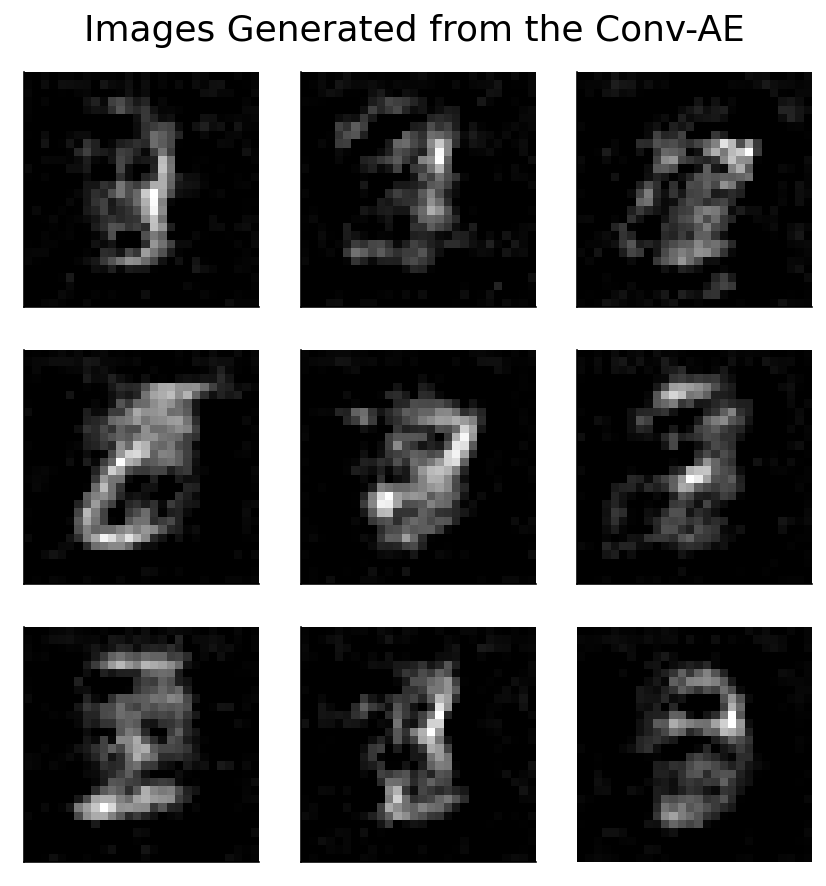

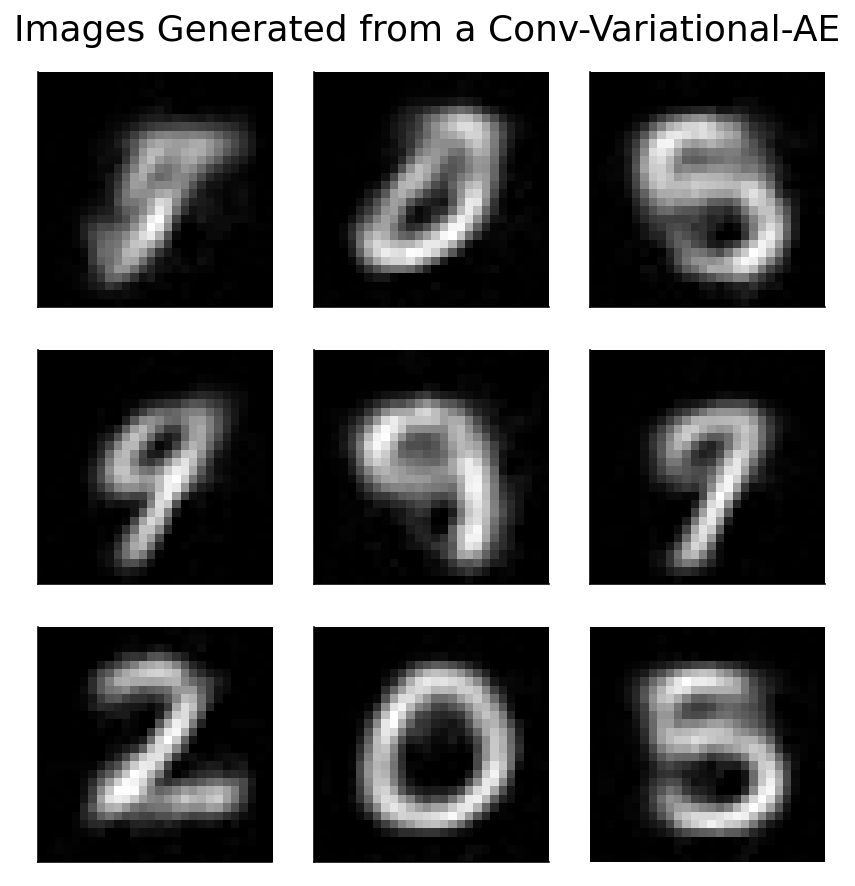

In [52]:
def generate_images(autoencoder, K, n_images=1):
  """Generate n_images 'new' images from the decoder part of the given
  autoencoder.

  returns (n_images, channels, height, width) tensor of images
  """
  # Concatenate tuples to get (n_images, channels, height, width)
  output_shape = (n_images,) + data_shape
  with torch.no_grad():
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    #raise NotImplementedError("Please complete the `generate_images` function!")
    ####################################################################
    # sample z from a unit gaussian, pass through autoencoder.decode()
    z = torch.randn(n_images, K)
    x = autoencoder.decode(z)

    return x.reshape(output_shape)


# add event to airtable
atform.add_event('Coding Exercise 4.2: Generating images')

set_seed(seed=SEED)
# Uncomment to test your solution
images = generate_images(trained_conv_AE, K, n_images=9)
plot_images(images, plt_title='Images Generated from the Conv-AE')
images = generate_images(trained_conv_VarAE, K_VAE, n_images=9)
plot_images(images, plt_title='Images Generated from a Conv-Variational-AE')

In [ ]:
# to_remove solution
def generate_images(autoencoder, K, n_images=1):
  """Generate n_images 'new' images from the decoder part of the given
  autoencoder.

  returns (n_images, channels, height, width) tensor of images
  """
  # Concatenate tuples to get (n_images, channels, height, width)
  output_shape = (n_images,) + data_shape
  with torch.no_grad():
    # sample z from a unit gaussian, pass through autoencoder.decode()
    z = torch.randn(n_images, K)
    x = autoencoder.decode(z)

    return x.reshape(output_shape)


# add event to airtable
atform.add_event('Coding Exercise 4.2: Generating images')

set_seed(seed=SEED)
## Uncomment to test your solution
images = generate_images(trained_conv_AE, K, n_images=9)
plot_images(images, plt_title='Images Generated from the Conv-AE')
images = generate_images(trained_conv_VarAE, K_VAE, n_images=9)
plot_images(images, plt_title='Images Generated from a Conv-Variational-AE')

### Think! 4.2: AutoEncoders vs. Variational AutoEncoders

Compare the images generated by the AutoEncoder to the images generated by the Variational AutoEncoder. You can run the code a few times to see a variety of examples.

Does one set look more like the training set (handwritten digits) than the other? What is driving this difference?

---
# Section 5: State of the art VAEs and Wrap-up (Bonus)

In [51]:
# @title Video 5: State-Of-The-Art VAEs
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1hg411M7KY", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"PXBl3KwRfh4", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: State-Of-The-Art VAEs')

display(out)

---
# Summary
Through this tutorial, we have learned
- What a generative model is and why we are interested in them.
- How latent variable models relate to generative models with the example of pPCA.
- What a basic AutoEncoder is and how they relate to other latent variable models.
- The basics of Variational AutoEncoders and how they function as generative models.
- An introduction to the broad applications of VAEs.

In the next two tutorials we will cover GANs and how to train them.

In [53]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )